# Data Challenge Solution
A solution by Bruno F. Bessa

## Description

### Data Challenge
Using the given dataset of transactions (notas fiscais eletrônicas) from a restaurant:

1. Parse and extract the data.
2. Identify a pattern on any set of fields that can help predict how much a customer will spend.
3. Calculate a sales forecast for the next week.

We recommend that you spend not more than 5 hours on the challenge.

### Evaluation criteria
1. Ability to read/parse a dataset from a file.
2. Understanding of common business data.
3. Basic knowledge of artificial intelligence.
4. Ability to build a model to identify correlations and patterns between fields.
5. Code design
6. Ability to write clear documentation

BONUS: Ability to build a forecast model.

### Submission
A link to the github repository.

Briefly explain the models that you used/built

## 1. Parse and extract data

For parsing the data from the source at github I used this snippet coded in R language:

In [ ]:
"""
"""This program parses the original data and exports a csv file."""

__author__      = "Bruno F. Bessa"

#Import modules
library(jsonlite)
library(tidyr)

# Set working directoty
path = "/Users/brunofbessa/Documents/professional/totvs/"
setwd(path)


# Download the file from github reposityry
url = "https://github.com/TOTVS/MDMStatic/raw/master/code-challenge/TOTVS%20Labs%20-%20AI%20Challenge%20-%20Dataset.zip"
download.file(url, destfile = "TOTVS Labs - AI Challenge - Dataset.zip", method="curl")

# Extract file from zip
unzip("TOTVS Labs - AI Challenge - Dataset.zip")

# Handle nested json file
# Extract nested field with fromJSON function (flatten = TRUE), then unnest the dets field and combine again with the other columns using index
json_data_full <- fromJSON("sample.txt", flatten = TRUE)

json_data_full$index <- seq.int(nrow(json_data_full))
json_data_full$dets <- NULL
json_data_unnested <- unnest(json_data_nested, dets)

# Merge the unnested dets fields with the rest of the dataset
json_data_full <- merge(json_data_full, json_data_unnested, by.x = "index", by.y = "index")

# Rename column names t use a convention without "."
names(json_data_full) <- c("index",
                            "versao_documento",
                            "complemento_valortotal",
                            "emit_cnpj",
                            "emit_xfant",
                            "emit_enderemit_fone",
                            "emit_enderemit_xbairro",
                            "emit_enderemit_xlgr",
                            "emit_enderemit_xmun",
                            "emit_enderemit_xpais",
                            "emit_enderemit_uf",
                            "ide_dhemi",
                            "ide_natop",
                            "infadic_infcpl",
                            "total_icmstot_vdesc",
                            "total_icmstot_vfrete",
                            "total_icmstot_voutro",
                            "total_icmstot_vprod",
                            "total_icmstot_vseg",
                            "total_icmstot_vtottrib",
                            "total_icmstot_vbc",
                            "total_icmstot_vbcst",
                            "total_icmstot_vcofins",
                            "total_icmstot_vicms",
                            "total_icmstot_vicmsdeson",
                            "total_icmstot_vii",
                            "total_icmstot_vipi",
                            "total_icmstot_vnf",
                            "total_icmstot_vpis",
                            "total_icmstot_vst",
                            "dets_nitem",
                            "dets_prod_indtot",
                            "dets_prod_qcom",
                            "dets_prod_ucom",
                            "dets_prod_vprod",
                            "dets_prod_vuncom",
                            "dets_prod_xprod")

# Export dataset for analysis with Python
write.csv(as.matrix(json_data_full), file = "sample.csv", row.names = FALSE)

"""

Since the data parsed and saved in a csv file I can now work with the data directly on Python.

In [3]:
# Set environment
import os
path = "/Users/brunofbessa/Documents/professional/totvs/"
os.chdir(path)

# Import needed modules

import pandas as pd
import numpy as np
import statsmodels
import seaborn as sns
sns.set(style="white")
import matplotlib.pyplot as plt
%matplotlib inline  
from IPython.display import Image
from IPython.core.display import HTML 

In [8]:
# Load data exported from R script into a pandas dataframe
sample_data = pd.read_csv("sample.csv")
##sample_data.head()

## 2 Pattern analysis

## 2.1 Preliminary data analysis

One can see that the present sample data concerns product sales of an asian food business. A document (determined by the index variable) may contain one ore more products sold. The variable total_icmstot_vnf is the total value of the products listed in that document. Under the structure of the "dets" variables he find the information about the individual products. The final price for the document is related with other variables in the following way:

$$ p_{total\_icmstot\_vnf} = \Sigma_{nitem} (q_{com}  v_{uncom}) (1)$$ 

There are some fields with information about the company with no variation through the data and, therefore, I can remove them from the analysis.

In [9]:
print(sample_data[["versao_documento",
             "emit_cnpj", 
             "emit_xfant", 
             "emit_enderemit_fone",
             "emit_enderemit_xbairro",
             "emit_enderemit_xlgr",
             "emit_enderemit_xmun",
             "emit_enderemit_xpais",
             "emit_enderemit_uf",
             "ide_natop",
             "total_icmstot_vfrete",
             "total_icmstot_voutro",
             "total_icmstot_vseg",
             "total_icmstot_vbc",
             "total_icmstot_vbcst",
             "total_icmstot_vcofins",
             "total_icmstot_vicms",
             "total_icmstot_vicmsdeson",
             "total_icmstot_vii"]].drop_duplicates())

# With the code above we see that these columns have no importance to
# a predictive model because there is no variation. The code below removes 
# the columns from the pandas dataframe.

sample_data.drop(columns = ["versao_documento",
             "emit_cnpj", 
             "emit_xfant", 
             "emit_enderemit_fone",
             "emit_enderemit_xbairro",
             "emit_enderemit_xlgr",
             "emit_enderemit_xmun",
             "emit_enderemit_xpais",
             "emit_enderemit_uf",
             "ide_natop",
             "total_icmstot_vfrete",
             "total_icmstot_voutro",
             "total_icmstot_vseg",
             "total_icmstot_vbc",
             "total_icmstot_vbcst",
             "total_icmstot_vcofins",
             "total_icmstot_vicms",
             "total_icmstot_vicmsdeson",
             "total_icmstot_vii"], inplace = True)

# This line is for convertion of epoch datetime value to a human readible
# format.
sample_data["ide_dhemi"] = pd.to_datetime(sample_data["ide_dhemi"],unit='s')

# Let us create a column with the individual value of products.
sample_data["dets_itemprice"] = sample_data["dets_prod_qcom"] * sample_data["dets_prod_vuncom"]

               versao_documento           emit_cnpj  emit_xfant  \
0                             1  01.234.567/0001-89  TOTVS Labs   
2553  list(`$numberLong` = "1")  01.234.567/0001-89  TOTVS Labs   

     emit_enderemit_fone  emit_enderemit_xbairro      emit_enderemit_xlgr  \
0         1-650-933-4902                     NaN  650 Castro St. unit 210   
2553      1-650-933-4902                     NaN  650 Castro St. unit 210   

     emit_enderemit_xmun emit_enderemit_xpais emit_enderemit_uf ide_natop  \
0          Mountain View        United States                CA     VENDA   
2553       Mountain View        United States                CA     VENDA   

      total_icmstot_vfrete  total_icmstot_voutro  total_icmstot_vseg  \
0                        0                     0                   0   
2553                     0                     0                   0   

      total_icmstot_vbc  total_icmstot_vbcst  total_icmstot_vcofins  \
0                     0                    0  

## 2.2 Understanding the variables

Checking the dets_prod_xprod variable we see that there 24 products were sold between 2016-01-05 12:01:54 and 2016-01-23 14:56:35:

In [10]:
sample_data["ide_dhemi"].min()
sample_data["ide_dhemi"].max()
sample_data["dets_prod_xprod"].unique()

array(['AGUA', 'BUFFET', 'REFRIGERANTE', 'SUCO', 'CERVEJA', 'CHA',
       'DOCINHOS', 'LIMONADA', 'HARUMAKI', 'CAFE EXPRESSO', 'BULE CHA',
       'TEMAKI', 'SAKE', 'CERVEJA LATA', 'WHISKY', 'SUSHI ESPECIAL',
       'SASHIMI', 'CAIPIROSKA', 'YAKISSOBA', 'SOBREMESA', 'CAIPIRINHA',
       'VINHO', 'BACARDI', 'URAMAKI'], dtype=object)

Let us check if the number of the table is a meaningfull variable by checking the distribution of sales across all tables.

/Users/brunofbessa/anaconda2/lib/python2.7/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


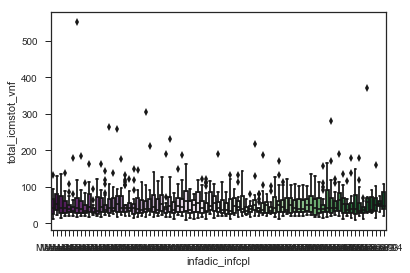

In [13]:
table_data = sample_data[["index", 
                          "infadic_infcpl", 
                          "total_icmstot_vnf"]].drop_duplicates()

sns.boxplot(x = "infadic_infcpl", 
            y = "total_icmstot_vnf", 
            data = table_data, 
            palette = "PRGn")

There is no significant difference amongst the distributions of the many tables of the sample. Even outliers may be regarded as an expected noise since there is less than a month of data.

I will continue to analyse data with the variables that can explain the scencario.

In [11]:
sample_data.drop(columns = ["complemento_valortotal",
                            "infadic_infcpl",
                            "total_icmstot_vdesc", 
                            "total_icmstot_vprod", 
                            "total_icmstot_vtottrib",
                            "total_icmstot_vipi", 
                            "total_icmstot_vpis", 
                            "total_icmstot_vst", 
                            "dets_nitem", 
                            "dets_prod_indtot",
                            "dets_prod_qcom",
                            "dets_prod_ucom",
                            "dets_prod_vuncom",
                            "dets_prod_vprod"], inplace = True)

Remaining variables:

In [15]:
sample_data.head()

,index,ide_dhemi,total_icmstot_vnf,dets_prod_xprod,dets_itemprice
0,1,2016-01-05 12:01:54,24.90,AGUA,3.5000
1,1,2016-01-05 12:01:54,24.90,BUFFET,21.4032
2,2,2016-01-05 12:03:52,92.55,BUFFET,83.5548
3,2,2016-01-05 12:03:52,92.55,REFRIGERANTE,9.0000
4,3,2016-01-05 12:16:40,57.87,SUCO,4.5000


Check the distributions os total sales for the different types of products:

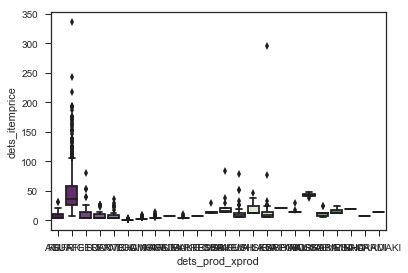

In [16]:
sns.boxplot(x = "dets_prod_xprod", 
            y = "dets_itemprice", 
            data = sample_data, 
            palette = "PRGn")

There are some products with assimetric distributions. At this moment this is not a problem since we will regard each product as a variable in a few steps. Even though, lets us check the aggredated values of sales for each product.

In [17]:
sample_data.groupby(["dets_prod_xprod"])["dets_itemprice"].describe()

,count,mean,std,min,25%,50%,75%,max
dets_prod_xprod,,,,,,,,
AGUA,417.0,6.188369,4.502722e+00,3.5000,3.5000,3.5000,10.5000,31.5000
BACARDI,1.0,7.000000,NaN,7.0000,7.0000,7.0000,7.0000,7.0000
BUFFET,1635.0,46.195450,2.932461e+01,7.6832,26.4796,36.6324,58.5158,335.8656
BULE CHA,8.0,8.200000,1.899005e-15,8.2000,8.2000,8.2000,8.2000,8.2000
CAFE EXPRESSO,20.0,4.200000,1.831019e+00,3.5000,3.5000,3.5000,3.5000,10.5000
CAIPIRINHA,7.0,15.428571,5.855400e+00,12.0000,12.0000,12.0000,18.0000,24.0000
CAIPIROSKA,9.0,17.000000,4.974937e+00,15.0000,15.0000,15.0000,15.0000,30.0000
CERVEJA,93.0,7.588710,5.969670e+00,4.5000,4.5000,4.5000,9.0000,36.0000
CERVEJA LATA,64.0,13.170312,1.229119e+01,6.0000,6.5000,9.8000,13.0000,78.4000


With the previous output we see that some products are seldom sold. Such products may require input technques in order to be trated as a time series.

At this poit I will produce a pivot table to generate variables representing sell of the products. Zero will be used as fill value because this method is coherent with the business rule. If the seel value is zero, the produxt wasn't sold.

In [12]:
sample_data_pivoted = sample_data.pivot_table(index = ["ide_dhemi"],
                                      values = ["dets_itemprice"],
                                      columns=["dets_prod_xprod"], 
                                      aggfunc=[np.sum],
                                      fill_value = 0)

sample_data_pivoted = sample_data_pivoted["sum"]["dets_itemprice"]
sample_data_pivoted["index"] = sample_data_pivoted.index
sample_data_pivoted.head()

dets_prod_xprod,AGUA,BACARDI,BUFFET,BULE CHA,CAFE EXPRESSO,CAIPIRINHA,CAIPIROSKA,CERVEJA,CERVEJA LATA,CHA,...,SASHIMI,SOBREMESA,SUCO,SUSHI ESPECIAL,TEMAKI,URAMAKI,VINHO,WHISKY,YAKISSOBA,index
ide_dhemi,,,,,,,,,,,,,,,,,,,,,
2016-01-05 12:01:54,3.5,0,21.4032,0.0,0.0,0,0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,2016-01-05 12:01:54
2016-01-05 12:03:52,0.0,0,83.5548,0.0,0.0,0,0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,2016-01-05 12:03:52
2016-01-05 12:16:40,0.0,0,53.3708,0.0,0.0,0,0,0.0,0.0,0,...,0.0,0.0,4.5,0.0,0.0,0,0,0.0,0.0,2016-01-05 12:16:40
2016-01-05 12:17:50,0.0,0,34.9860,0.0,0.0,0,0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,2016-01-05 12:17:50
2016-01-05 12:18:35,0.0,0,46.2364,0.0,0.0,0,0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,2016-01-05 12:18:35


The step below is necessary to extract the index values as columns and use in another dataframe.

In [13]:
# Convert pivoted table to matrix
sample_data_matrix = sample_data_pivoted.as_matrix()

# Give proper names to columns of the upcoming dataframe.
columns = ["agua",
           "bacardi",
           "buffet",
           "bule_cha",
           "cafe_expresso",
           "caipirinha",
           "caipiroska",
           "cerveja",
           "cerveja_lata",
           "cha",
           "docinhos",
           "harumaki",
           "limonada",
           "refrigerante",
           "sake",
           "sashimi",
           "sobremesa",
           "suco",
           "sushi_especial",
           "temaki",
           "uramaki",
           "vinho",
           "whisky",
           "yakissoba", 
           "date_time"]

# Create new dataframe.
sample_data_pivoted2 = pd.DataFrame(sample_data_matrix)
sample_data_pivoted2.columns = columns
sample_data_pivoted2.head()

,agua,bacardi,buffet,bule_cha,cafe_expresso,caipirinha,caipiroska,cerveja,cerveja_lata,cha,...,sashimi,sobremesa,suco,sushi_especial,temaki,uramaki,vinho,whisky,yakissoba,date_time
0,3.5,0,21.4032,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2016-01-05 12:01:54
1,0,0,83.5548,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2016-01-05 12:03:52
2,0,0,53.3708,0,0,0,0,0,0,0,...,0,0,4.5,0,0,0,0,0,0,2016-01-05 12:16:40
3,0,0,34.986,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2016-01-05 12:17:50
4,0,0,46.2364,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2016-01-05 12:18:35


Create the time series and check for usefull information with a correlation matrix:

In [14]:
# Create time series. In fact there are many series and each one represents the total sells of each product.
time_series_data =  sample_data_pivoted2.set_index(["date_time"])
time_series_sum = time_series_data.groupby(time_series_data.index.day).sum()

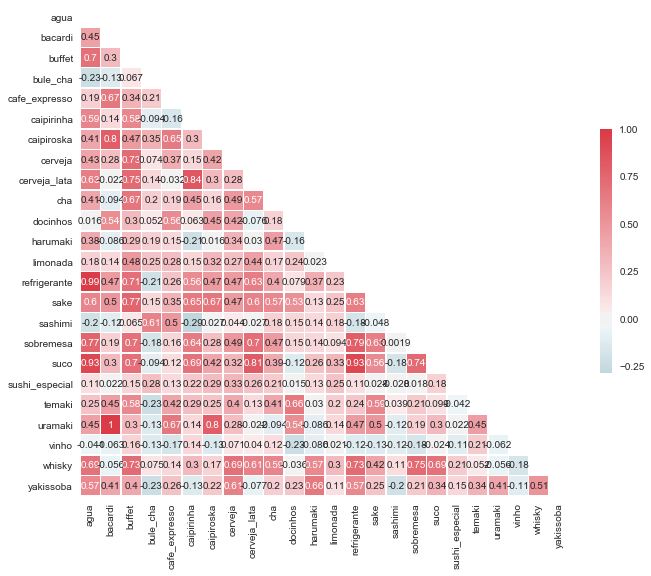

In [15]:
# Calculate correlation matrix
corr = time_series_sum.corr()

# Template of this plot from seaborn.pydata.org
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask = mask, cmap = cmap, center=0,
            square = True, linewidths = .5, annot = True, cbar_kws = {"shrink": .5})

With the correlaiton matrix above we can see that there are patterns n the data such as:
* non alcoholic beverages are very likely to occur together
* alcoholic beverages are ver likely to occur together 
* buffet is unlikely to occur with other individual dishes

## 2.3 Conclusion of Part 2

Since there is a very clear linear mathematical relation between the total spent and the amount spent on each option from the menu given by (1), I judge that a predictive model for the total amount spent does not bring value the the analysis.

## 3 Sales forecast model

In order to create a forecast model, it is necessary to analyse the time series created in the previous section. I choose to work with one series of the total spent in each day. 

In [16]:
time_series_sum["total"] =  (time_series_sum["agua"] +
                            time_series_sum["bacardi"] +
                            time_series_sum["buffet"] +
                            time_series_sum["bule_cha"] +
                            time_series_sum["cafe_expresso"] +
                            time_series_sum["caipirinha"] +
                            time_series_sum["caipiroska"] +
                            time_series_sum["cerveja"] +
                            time_series_sum["cerveja_lata"] +
                            time_series_sum["cha"] +
                            time_series_sum["docinhos"] +
                            time_series_sum["harumaki"] +
                            time_series_sum["limonada"] +
                            time_series_sum["refrigerante"] +
                            time_series_sum["sake"] +
                            time_series_sum["sashimi"] +
                            time_series_sum["sobremesa"] +
                            time_series_sum["suco"] +
                            time_series_sum["sushi_especial"] +
                            time_series_sum["temaki"] +
                            time_series_sum["uramaki"] +
                            time_series_sum["vinho"] +
                            time_series_sum["whisky"] +
                            time_series_sum["yakissoba"])

# New series with only the total variable
model_series = time_series_sum[["total"]]

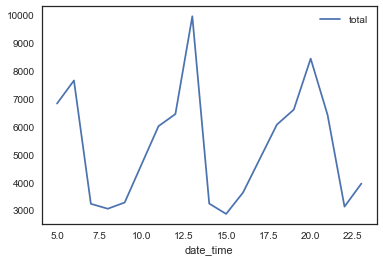

In [84]:
model_series.plot()

From the plot above, it is possible to say that:
* the series does not have trend component
* the series has a visible seasonal component
* the series may be non-stationay because the mean is not constant.

to check the stationarity of a series, the <strong>Dickey-Fuller test</strong> will be used:

In [98]:
DF_result = statsmodels.tsa.stattools.adfuller(model_series["total"])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % DF_result[1])
print('Critical Values:')
for key, value in DF_result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 0.000000
p-value: 0.958532
Critical Values:
	5%: -3.367
	1%: -4.665
	10%: -2.803


Since the ADF statistic is greater than the critical value, we cannot reject the null hypotesis and then the series will be treated as nonstationary. Therefore, an ARIMAX model is out of order because we would have to change the scale of the series and introduce unnecessary complexity to the model.

The class of Exponential Weighted Models can handle series with like model_series with far less compexity. The multiplicative Winters Model accomodate trend, seasonal, and irregular variation and is a reliable option. In this case only the seasonal component coefficient is needed. 

For simplicity, just as I did with parsing the document, I choose to handle the forecast with R language.

In [21]:
model_series["index"] = model_series.index
model_series.to_csv("model_series.csv", header = True, index = False)

/Users/brunofbessa/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


The folowing snippet was used as R code:

From this code it is possible to see that the series has a seasonal component of size 7. This is clear as we see the strong autocorrelation of lag 7 (and multiples of 7) of the ACF plot:

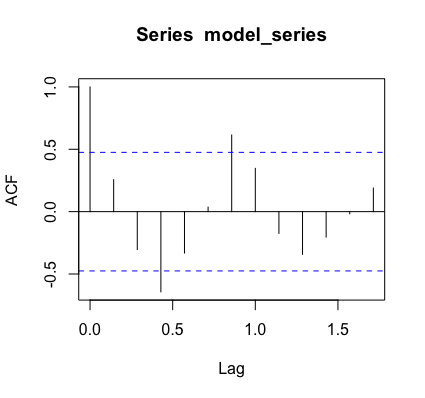

In [5]:
display(Image("/Users/brunofbessa/Documents/professional/totvs/RplotACF.png"))

At last it was possible to generate a forecast model usin Winters algorithm. The parameters of the model are:

In [ ]:
"""
Holt-Winters exponential smoothing with trend and additive seasonal component.

Call:
HoltWinters(x = model_series)

Smoothing parameters:
 alpha: 0
 beta : 0
 gamma: 1
 
 
Performance measure:
SSE: num 25684909
"""

And since gamma is the smoothing factor for the seasonal component we see that only this effect was needed in the model. The forecast produed by this model was:

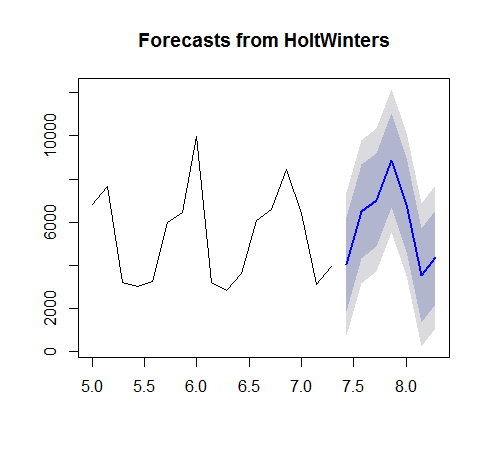

In [7]:
display(Image("/Users/brunofbessa/Documents/professional/totvs/RplotForecast.png"))

## Conclusions

Predictive models can be a very usefull set of tools to produce insights about data, but most of the times a proper exploratory analysis makes the process easier. The forecast proposed in the present challenge is a good example of choosing a simpler but effective technique such as EWM and getting good results.

Any questions addressed to brunofbessa at Gmail will be gladly replied.